In [2]:
import pandas as pd

# Load CSV file
df = pd.read_csv("/kaggle/input/online-retail-uci-dataset/Online Retail.csv")

# Preview
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
# Remove missing CustomerID (required for RFM)
df = df[pd.notnull(df['CustomerID'])]

# Remove cancelled orders (negative quantities)
df = df[df['Quantity'] > 0]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


/tmp/ipykernel_36/3909762101.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [5]:
# Create TotalPrice column (Quantity × UnitPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': 'sum'                                  # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# View result
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [6]:
# Assign RFM scores from 1 to 4 (higher is better)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

# Create RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,2,7,4310.00,4,4,4,444,12
12348.0,75,4,1797.24,2,3,4,234,9
12349.0,19,1,1757.55,3,1,4,314,8
12350.0,310,1,334.40,1,1,2,112,4


In [7]:
# Define segments
def segment_customer(score):
    if score >= 9:
        return 'Loyal'
    elif score >= 6:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# View count per segment
rfm['Segment'].value_counts()


Segment
Loyal        1680
Potential    1369
At Risk      1290
Name: count, dtype: int64

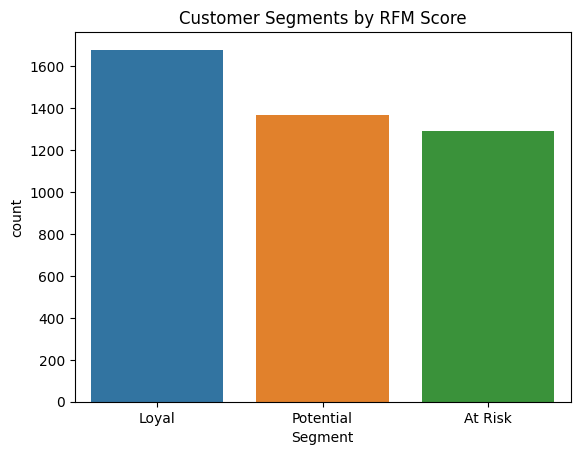

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=rfm, x='Segment', order=['Loyal', 'Potential', 'At Risk'])
plt.title("Customer Segments by RFM Score")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


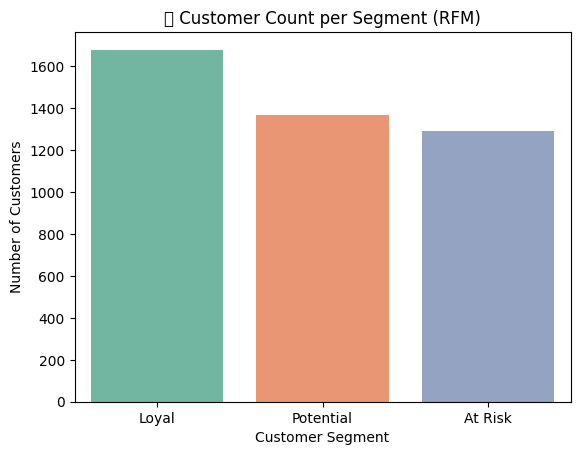

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot of customer segments
sns.countplot(data=rfm, x='Segment', order=['Loyal', 'Potential', 'At Risk'], palette='Set2')
plt.title("📊 Customer Count per Segment (RFM)")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


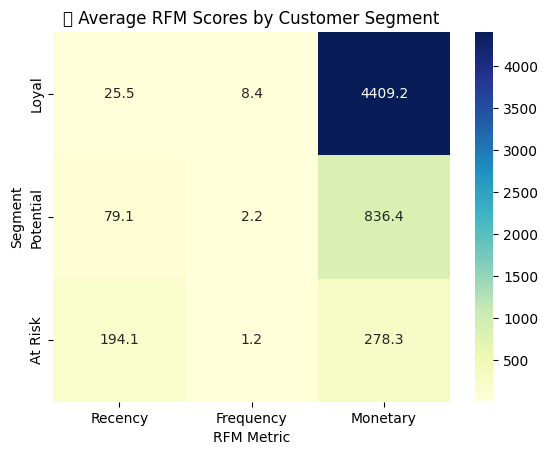

In [10]:
# Group by Segment and get average RFM scores
rfm_segment_avg = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

# Reorder index if needed
rfm_segment_avg = rfm_segment_avg.loc[['Loyal', 'Potential', 'At Risk']]

# Heatmap of average R, F, M per segment
sns.heatmap(rfm_segment_avg, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title("🔥 Average RFM Scores by Customer Segment")
plt.ylabel("Segment")
plt.xlabel("RFM Metric")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


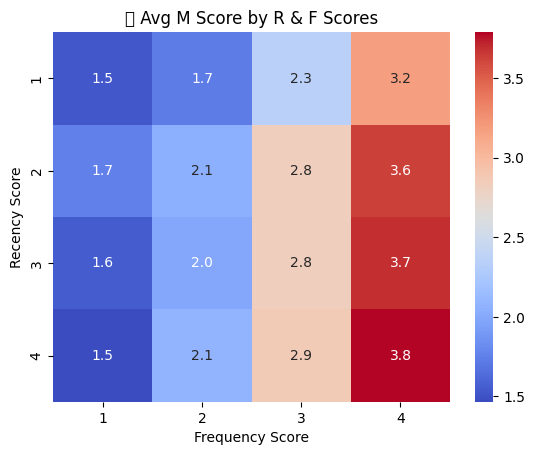

In [11]:
# Count of each RFM score combination
rfm_matrix = rfm.groupby(['R_Score', 'F_Score'])['M_Score'].mean().unstack()

# Heatmap
sns.heatmap(rfm_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("💡 Avg M Score by R & F Scores")
plt.xlabel("Frequency Score")
plt.ylabel("Recency Score")
plt.show()


In [12]:
| **Segment**                          | **Customer Behavior**                                        | **Marketing Idea**                                                            |
| ------------------------------------ | ------------------------------------------------------------ | ----------------------------------------------------------------------------- |
| **Loyal**                            | Frequent buyers, spent recently, high value                  | 🎁 Offer loyalty rewards (points, early access), personalized recommendations |
| **Potential**                        | Moderate or recent activity but not frequent or big spenders | 💌 Send targeted offers, product bundles, first-time buyer discounts          |
| **At Risk**                          | Haven’t bought in a long time, low spend or infrequent       | 🔔 Re-engagement campaign: limited-time discounts, “We miss you” emails       |
| **New** *(optional)*                 | Recent first-time buyer                                      | 📩 Welcome series with small discount, onboarding or product tips             |
| **Big Spenders** *(subset of Loyal)* | High monetary score                                          | 🎉 VIP treatment: premium service, high-end product alerts                    |
| **Low Value** *(optional)*           | Low RFM in all — one-time or unprofitable buyers             | 📉 Limit cost-intensive promotions, send curated low-cost product suggestions |


SyntaxError: invalid character '🎁' (U+1F381) (196125670.py, line 3)